In [1]:
%load_ext autoreload 
%autoreload 2

In [1]:
from glob import glob 
import pandas as pd 
from fastcore.xtras import load_pickle 

from gptchem.data import get_hea_phase_data
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from gptchem.evaluator import evaluate_classification
from gptchem.formatter import ClassificationFormatter
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])
%matplotlib inline


## Get the dummy metrics

In [2]:
data = get_hea_phase_data()

In [15]:
estimators = ['uniform', 'stratified', 'most_frequent']
results = []
train_sizes = [10, 20, 50, 100, 200]
for i in range(10): 
    for estimator in estimators:
        for train_size in train_sizes: 
            train, test = train_test_split(data, train_size=train_size, test_size=250, stratify=data['phase_binary_encoded'], random_state=i) 
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train['Alloy'], train['phase_binary_encoded'])
            predictions = classifier.predict(test['Alloy'])
            res = evaluate_classification(test['phase_binary_encoded'], predictions)
            res['train_size'] = train_size
            res['estimator'] = estimator
            results.append(res)

In [16]:
dummy_results = pd.DataFrame(results)

In [17]:
dummy_grouped = dummy_results[['train_size', 'estimator', 'accuracy', 'f1_macro', 'f1_micro', 'kappa']].groupby([ 'estimator', 'train_size']).agg(['mean', 'std']) 

In [18]:
dummy_grouped

accuracy            f1_macro           f1_micro  \
                             mean       std      mean       std     mean   
estimator     train_size                                                   
most_frequent 10           0.5000  0.000000  0.333333  0.000000   0.5000   
              20           0.5000  0.000000  0.333333  0.000000   0.5000   
              50           0.5000  0.000000  0.333333  0.000000   0.5000   
              100          0.5000  0.000000  0.333333  0.000000   0.5000   
              200          0.5000  0.000000  0.333333  0.000000   0.5000   
stratified    10           0.5040  0.014360  0.503090  0.013865   0.5040   
              20           0.4992  0.023156  0.498800  0.023299   0.4992   
              50           0.5024  0.036035  0.501997  0.036444   0.5024   
              100          0.5000  0.025228  0.499828  0.025210   0.5000   
              200          0.4868  0.025372  0.486496  0.025365   0.4868   
uniform       10           0.5036  0.033543  0.503406  0.033695   0.5036   
              20           0.5008  0.038172  0.500585  0.038161   0.5008   
              50           0.5100  0.033373  0.509645  0.033086   0.5100   
              100          0.4960  0.025368  0.495242  0.025097   0.4960   
              200          0.4944  0.028108  0.493302  0.027781   0.4944   

                                           kappa            
                               std          mean       std  
estimator     train_size                                    
most_frequent 10          0.000000  0.000000e+00  0.000000  
              20          0.000000  0.000000e+00  0.000000  
              50          0.000000  0.000000e+00  0.000000  
              100         0.000000  0.000000e+00  0.000000  
              200         0.000000  0.000000e+00  0.000000  
stratified    10          0.014360  8.000000e-03  0.028721  
              20          0.023156 -1.600000e-03  0.046311  
              50          0.036035  4.800000e-03  0.072069  
              100         0.025228  1.110223e-17  0.050456  
              200         0.025372 -2.640000e-02  0.050744  
uniform       10          0.033543  7.200000e-03  0.067087  
              20          0.038172  1.600000e-03  0.076343  
              50          0.033373  2.000000e-02  0.066747  
              100         0.025368 -8.000000e-03  0.050737  
              200         0.028108 -1.120000e-02  0.056215

## Load the results

In [19]:
all_out = glob("out/**/*.pkl")

In [20]:
all_out = [load_pickle(p) for p in all_out]

In [21]:
extracted_res = []

for out in all_out: 
    res = {
        'base_model': out['base_model'],
        'train_size': out['train_size'],
        'test_size': out['test_size'],
        'n_epochs': out['n_epochs'],
        'learning_rate_multiplier': out['learning_rate_multiplier'],
        'frac_valid': out['frac_valid'],
        'accuracy': out['accuracy'],
        'f1_macro': out['f1_macro'],
        'f1_micro': out['f1_micro'],
        'kappa': out['kappa'],
    }

    extracted_res.append(res)

In [22]:
extracted_res = pd.DataFrame(extracted_res)

In [23]:
extracted_res_grouped = extracted_res.groupby(['train_size']).agg(['mean', 'std'])

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_45745/3212784846.py:1: FutureWarning: ['base_model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  extracted_res_grouped = extracted_res.groupby(['train_size']).agg(['mean', 'std'])


In [24]:
extracted_res_grouped

test_size      n_epochs      learning_rate_multiplier       \
                mean  std     mean  std                     mean  std   
train_size                                                              
10             250.0  0.0      8.0  0.0                     0.02  0.0   
20             250.0  0.0      8.0  0.0                     0.02  0.0   
50             250.0  0.0      8.0  0.0                     0.02  0.0   
100            250.0  0.0      8.0  0.0                     0.02  0.0   
200            250.0  0.0      8.0  0.0                     0.02  0.0   

           frac_valid       accuracy            f1_macro            f1_micro  \
                 mean  std      mean       std      mean       std      mean   
train_size                                                                     
10                1.0  0.0  0.885600  0.045848  0.884522  0.047488  0.885600   
20                1.0  0.0  0.891600  0.054600  0.890336  0.056011  0.891600   
50                1.0  0.0  0.932400  0.033224  0.932225  0.033577  0.932400   
100               1.0  0.0  0.960444  0.015930  0.960406  0.015974  0.960444   
200               1.0  0.0  0.964400  0.008527  0.964376  0.008544  0.964400   

                         kappa            
                 std      mean       std  
train_size                                
10          0.045848  0.771200  0.091696  
20          0.054600  0.783200  0.109200  
50          0.033224  0.864800  0.066448  
100         0.015930  0.920889  0.031861  
200         0.008527  0.928800  0.017054

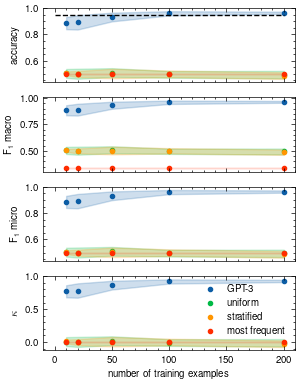

In [31]:
fig, ax = plt.subplots(4,1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex=True)

# accuracy
ax[0].scatter(
    extracted_res_grouped.index, 
    extracted_res_grouped['accuracy']['mean'],
    label='GPT-3',
    marker='o',
)
ax[0].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped['accuracy']['mean'] - extracted_res_grouped['accuracy']['std'],
    extracted_res_grouped['accuracy']['mean'] + extracted_res_grouped['accuracy']['std'],
    alpha=.2,
    color='C0',
)

# add the dummy models 
for i, estimator in enumerate(estimators):
    ax[0].scatter(
        dummy_grouped.loc[estimator, :]['accuracy']['mean'].index,
        dummy_grouped.loc[estimator, :]['accuracy']['mean'],
        label=estimator.replace('_', ' '),
        marker='o',
        color=f'C{i+1}'
    )
    ax[0].fill_between(
        dummy_grouped.loc[estimator, :]['accuracy']['mean'].index,
        dummy_grouped.loc[estimator, :]['accuracy']['mean'] - dummy_grouped.loc[estimator, :]['accuracy']['std'],
        dummy_grouped.loc[estimator, :]['accuracy']['mean'] + dummy_grouped.loc[estimator, :]['accuracy']['std'],
        alpha=.2,
        color=f'C{i+1}',
    )

# f1 macro 
ax[1].scatter(
    extracted_res_grouped.index, 
    extracted_res_grouped['f1_macro']['mean'],
    label='GPT-3',
    marker='o',
)
ax[1].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped['f1_macro']['mean'] - extracted_res_grouped['f1_macro']['std'],
    extracted_res_grouped['f1_macro']['mean'] + extracted_res_grouped['f1_macro']['std'],
    alpha=.2,
    color='C0',
)

# add the dummy models 
for i, estimator in enumerate(estimators):
    ax[1].scatter(
        dummy_grouped.loc[estimator, :]['f1_macro']['mean'].index,
        dummy_grouped.loc[estimator, :]['f1_macro']['mean'],
        label=estimator.replace('_', ' '),
        marker='o',
        color=f'C{i+1}'
    )
    ax[1].fill_between(
        dummy_grouped.loc[estimator, :]['f1_macro']['mean'].index,
        dummy_grouped.loc[estimator, :]['f1_macro']['mean'] - dummy_grouped.loc[estimator, :]['f1_macro']['std'],
        dummy_grouped.loc[estimator, :]['f1_macro']['mean'] + dummy_grouped.loc[estimator, :]['f1_macro']['std'],
        alpha=.2,
        color=f'C{i+1}',
    )

# f1 micro 

ax[2].scatter(
    extracted_res_grouped.index, 
    extracted_res_grouped['f1_micro']['mean'],
    label='GPT-3',
    marker='o',
)
ax[2].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped['f1_micro']['mean'] - extracted_res_grouped['f1_micro']['std'],
    extracted_res_grouped['f1_micro']['mean'] + extracted_res_grouped['f1_micro']['std'],
    alpha=.2,
    color='C0',
)

# add the dummy models 
for i, estimator in enumerate(estimators):
    ax[2].scatter(
        dummy_grouped.loc[estimator, :]['f1_micro']['mean'].index,
        dummy_grouped.loc[estimator, :]['f1_micro']['mean'],
        label=estimator.replace('_', ' '),
        marker='o',
        color=f'C{i+1}'
    )
    ax[2].fill_between(
        dummy_grouped.loc[estimator, :]['f1_micro']['mean'].index,
        dummy_grouped.loc[estimator, :]['f1_micro']['mean'] - dummy_grouped.loc[estimator, :]['f1_micro']['std'],
        dummy_grouped.loc[estimator, :]['f1_micro']['mean'] + dummy_grouped.loc[estimator, :]['f1_micro']['std'],
        alpha=.2,
        color=f'C{i+1}',
    )


# kappa
ax[3].scatter(
    extracted_res_grouped.index, 
    extracted_res_grouped['kappa']['mean'],
    label='GPT-3',
    marker='o',
)
ax[3].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped['kappa']['mean'] - extracted_res_grouped['kappa']['std'],
    extracted_res_grouped['kappa']['mean'] + extracted_res_grouped['kappa']['std'],
    alpha=.2,
    color='C0',
)

# add the dummy models 
for i, estimator in enumerate(estimators):
    ax[3].scatter(
        dummy_grouped.loc[estimator, :]['kappa']['mean'].index,
        dummy_grouped.loc[estimator, :]['kappa']['mean'],
        label=estimator.replace('_', ' '),
        marker='o',
        color=f'C{i+1}'
    )
    ax[3].fill_between(
        dummy_grouped.loc[estimator, :]['kappa']['mean'].index,
        dummy_grouped.loc[estimator, :]['kappa']['mean'] - dummy_grouped.loc[estimator, :]['kappa']['std'],
        dummy_grouped.loc[estimator, :]['kappa']['mean'] + dummy_grouped.loc[estimator, :]['kappa']['std'],
        alpha=.2,
        color=f'C{i+1}',
    )

ax[0].hlines(0.95, 0, 200, color='k', linestyle='--')

ax[0].set_ylabel("accuracy")
ax[1].set_ylabel(r"F$_1$ macro")
ax[2].set_ylabel(r"F$_1$ micro")
ax[3].set_ylabel(r"$\kappa$")
ax[-1].legend()
ax[-1].set_xlabel("number of training examples")
fig.savefig('hea_single_vs_multiphase_classifier.pdf', bbox_inches='tight')

In [ ]:
dummy_grouped

accuracy            f1_macro           f1_micro  \
                             mean       std      mean       std     mean   
estimator     train_size                                                   
most_frequent 10           0.5000  0.000000  0.166667  0.000000   0.5000   
              20           0.5000  0.000000  0.166667  0.000000   0.5000   
              50           0.5000  0.000000  0.166667  0.000000   0.5000   
              100          0.5000  0.000000  0.166667  0.000000   0.5000   
              200          0.5000  0.000000  0.166667  0.000000   0.5000   
              500          0.5000  0.000000  0.166667  0.000000   0.5000   
stratified    10           0.3480  0.021909  0.263624  0.021630   0.3480   
              20           0.3436  0.025609  0.256689  0.027524   0.3436   
              50           0.3324  0.017225  0.251264  0.025716   0.3324   
              100          0.3384  0.037533  0.252935  0.034429   0.3384   
              200          0.3476  0.027806  0.257097  0.028332   0.3476   
              500          0.3276  0.015714  0.246373  0.018071   0.3276   
uniform       10           0.2548  0.017694  0.234452  0.021782   0.2548   
              20           0.2420  0.024748  0.220566  0.024096   0.2420   
              50           0.2480  0.018282  0.227158  0.019982   0.2480   
              100          0.2516  0.035700  0.233411  0.034235   0.2516   
              200          0.2512  0.031485  0.232781  0.036021   0.2512   
              500          0.2636  0.032901  0.244169  0.030645   0.2636   

                                       kappa            
                               std      mean       std  
estimator     train_size                                
most_frequent 10          0.000000  0.000000  0.000000  
              20          0.000000  0.000000  0.000000  
              50          0.000000  0.000000  0.000000  
              100         0.000000  0.000000  0.000000  
              200         0.000000  0.000000  0.000000  
              500         0.000000  0.000000  0.000000  
stratified    10          0.021909  0.015738  0.038639  
              20          0.025609  0.008684  0.040855  
              50          0.017225 -0.008063  0.033768  
              100         0.037533  0.002106  0.051276  
              200         0.027806  0.014798  0.042376  
              500         0.015714 -0.009669  0.031267  
uniform       10          0.017694  0.006806  0.024330  
              20          0.024748 -0.008124  0.029777  
              50          0.018282 -0.004788  0.026487  
              100         0.035700  0.006987  0.044053  
              200         0.031485  0.006417  0.044121  
              500         0.032901  0.017047  0.040663

In [26]:
dummy_grouped.loc['most_frequent']

accuracy       f1_macro      f1_micro      kappa     
               mean  std      mean  std     mean  std  mean  std
train_size                                                      
10              0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
20              0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
50              0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
100             0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
200             0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0